In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#  Veri
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
val_path   = "/kaggle/input/intel-image-classification/seg_test/seg_test"

In [4]:
# Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150,150),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("Sınıflar:", class_names)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [5]:
# Model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
base_model.trainable = False  # önce dondur

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

I0000 00:00:1758904586.931697      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758904586.932404      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 2,098,950 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)

In [7]:
# Eğitim
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1758904592.559262     115 service.cc:148] XLA service 0x7f235400eae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758904592.560875     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758904592.560898     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758904593.078131     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/439 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.1562 - loss: 2.2980   

I0000 00:00:1758904601.467351     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 208s 449ms/step - accuracy: 0.6039 - loss: 1.0226 - val_accuracy: 0.8453 - val_loss: 0.4423 - learning_rate: 1.0000e-04
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 238ms/step - accuracy: 0.7920 - loss: 0.5518 - val_accuracy: 0.8627 - val_loss: 0.3846 - learning_rate: 1.0000e-04
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 236ms/step - accuracy: 0.8088 - loss: 0.5157 - val_accuracy: 0.8497 - val_loss: 0.3905 - learning_rate: 1.0000e-04
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 235ms/step - accuracy: 0.8244 - loss: 0.4831 - val_accuracy: 0.8593 - val_loss: 0.3757 - learning_rate: 1.0000e-04
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 104s 237ms/step - accuracy: 0.8250 - loss: 0.4692 - val_accuracy: 0.8677 - val_loss: 0.3515 - learning_rate: 1.0000e-04
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 103s 234ms/step - accuracy: 0.8323 - loss: 0.4429 - val_accuracy: 0.8693 - val_loss: 0.3441 - learning_rate: 1.0000e-04
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 101s 230ms/

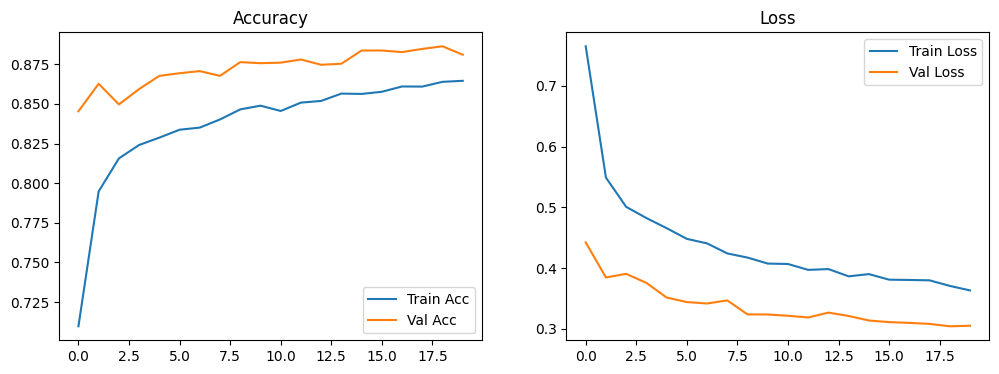

In [8]:
# Accuracy & Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step


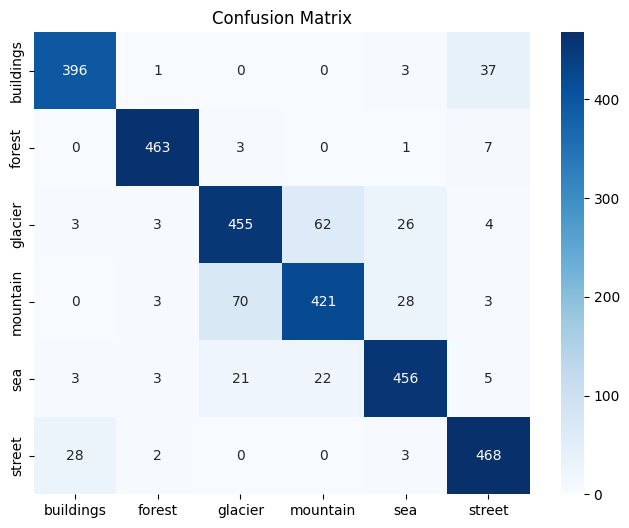

In [9]:
# Confusion Matrix 
val_pred = model.predict(val_generator)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = val_generator.classes

cm = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()


In [10]:
# Classification Report 
print(classification_report(true_classes, val_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.92      0.91      0.91       437
      forest       0.97      0.98      0.98       474
     glacier       0.83      0.82      0.83       553
    mountain       0.83      0.80      0.82       525
         sea       0.88      0.89      0.89       510
      street       0.89      0.93      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

